## With target y = (n) classes 

We made 100 clusters with KMEans in the previous notebook
In this notebook the targets will be these clusters!

In [1]:
"""
#TensorFlow 2.10 was the last TensorFlow release that supported GPU on native-Windows.
!pip install "tensorflow-gpu<2.11"  
!pip install --upgrade pip
!pip install pandas
!pip install -U scikit-learn
!pip install transformers
!pip install matplotlib
!pip install numpy

#for AdamW optimizer
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

"""

'#TensorFlow 2.10 was the last TensorFlow release that supported GPU on native-Windows.\n!pip install "tensorflow-gpu<2.11"  \n!pip install --upgrade pip\n!pip install pandas\n!pip install -U scikit-learn\n!pip install transformers\n!pip install matplotlib\n!pip install numpy\n!pip install "tf-models-official<2.11"\n\n\nfor AdamW optimizer\n!pip install -q -U "tensorflow-text==2.8.*"\n!pip install -q tf-models-official==2.7.0\n\n'

In [2]:
import pandas as pd
import tensorflow as tf

df_model=pd.read_csv('../csv/TRAIN_DS_Clusters.csv', sep=";") 
df_model.head()

,0,text,cluster
0,10202-2018-012766,sinds vertegenwoordiger uitzondering boorders ...,59
1,10202-2020-013175,uitzondering verhoogd boorders gewone werk gek...,59
2,10205-2018-004963,berekend zoals xiv behoud uitzondering verhoog...,59
3,10206-2019-003872,winst gemaakt voorafgaandelijk hierboven opges...,10
4,10206-2020-000814,verzoeningscomité zetelt zesde dienstjaar verh...,59


### Create OHE dataframe for targets

For **CategoricalCrossEntropy** we need to OHE the target. *We use this method because it works*<br>
<br>
For **SparseCategoricalCrossEntropy**  Convert y from pd Series to pd dataframe<br>
If you want to use cluster targets as 1D integers
*This method gives a Nan with the loss function (why?)*

In [3]:
 
X = df_model["text"].astype(str).tolist()

#y = df_model['cluster'].to_frame() 
y = pd.get_dummies(df_model['cluster'])

In [4]:
# Make train test val 

from sklearn.model_selection import train_test_split

# Split Train and Validation data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1)

# Keep some data for inference (testing)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)
print ('X_train',len(X_train))
print ('X_test',len(X_test))
print ('X_val',len(X_val))


X_train 4701
X_test 554
X_val 830


### Initiate GPU with maximum memory allocation limit (4Gb, 8Gb, ..)

In [5]:


print (tf.__version__)
# Ref: https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)]) # Notice here
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2.8.4
1 Physical GPUs, 1 Logical GPUs
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14619692129399257296
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8589934592
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8829446596162706217
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [6]:
from transformers import AutoTokenizer
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-base")
model = TFRobertaForSequenceClassification.from_pretrained("pdelobelle/robbert-v2-dutch-base", num_labels=len(set(y)))

c:\becode\tf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Tokenize the dataset

With RobertaTokenizer we make tensors from the processed texts

- max_length should be lower than 512
- On average the length of our processed text is 

In [7]:
tokenizer = RobertaTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-base")

max_length=368

train_encodings = tokenizer(X_train, max_length=max_length, truncation=True, padding=True)
val_encodings   = tokenizer(X_val,   max_length=max_length, truncation=True, padding=True)
test_encodings  = tokenizer(X_test,  max_length=max_length, truncation=True, padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)) 

### We use AdamW optimizer

This gives far better results than sgd

In [8]:
# Create AdamW optimizer

from official.nlp import optimization 
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

c:\becode\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


### Set LOSS & METRICS
IF we have targets as **integers** and not as one_hot_encoded dataframe, we have to use

**SparseCategoricalCrossentropy** instead of *CategoricalCrossentropy*
and 

**SparseCategoricalAccuracy** instead of *CategoricalAccuracy*

In [9]:
"""# Compile the model

loss= tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction="auto",
    name="sparse_categorical_crossentropy",
) 
metrics = tf.keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy", dtype=None)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()"""

'# Compile the model\n\nloss= tf.keras.losses.SparseCategoricalCrossentropy(\n    from_logits=False,\n    reduction="auto",\n    name="sparse_categorical_crossentropy",\n) \nmetrics = tf.keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy", dtype=None)\n\nmodel.compile(optimizer=optimizer, loss=loss, metrics=metrics)\n\nmodel.summary()'

### But we are using OHE columns
Because loss turns into nan with above loss function

**from logits=True**<br>
The from_logits=True attribute inform the loss function that the output values generated by the model are not normalized, a.k.a. logits. In other words, the softmax function has not been applied on them to produce a probability distribution. Therefore, the output layer in this case does not have a softmax activation function.

In [10]:
# Compile the model

loss=tf.keras.losses.CategoricalCrossentropy(
    from_logits=True,
    label_smoothing=0.0,
    axis=-1,
    reduction="auto",
    name="categorical_crossentropy",
)
metrics = tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 116171520 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 667492    
 ficationHead)                                                   
                                                                 
Total params: 116,839,012
Trainable params: 116,839,012
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Run the model
 
tf.config.run_functions_eagerly(True)

BATCH_SIZE = 4
EPOCHS =12
history=model.fit(
    train_dataset.batch(BATCH_SIZE) ,
    epochs=EPOCHS,
    validation_data=val_dataset.batch(BATCH_SIZE)
)


Epoch 1/12
1176/1176 [==============================] - 529s 449ms/step - loss: 4.2537 - categorical_accuracy: 0.0938 - val_loss: 3.8176 - val_categorical_accuracy: 0.1458
Epoch 2/12
1176/1176 [==============================] - 545s 464ms/step - loss: 3.4599 - categorical_accuracy: 0.2468 - val_loss: 2.9823 - val_categorical_accuracy: 0.3639
Epoch 3/12
1176/1176 [==============================] - 529s 450ms/step - loss: 2.6513 - categorical_accuracy: 0.4229 - val_loss: 2.3404 - val_categorical_accuracy: 0.4735
Epoch 4/12
1176/1176 [==============================] - 525s 446ms/step - loss: 2.0837 - categorical_accuracy: 0.5314 - val_loss: 1.9487 - val_categorical_accuracy: 0.5783
Epoch 5/12
1176/1176 [==============================] - 520s 443ms/step - loss: 1.6593 - categorical_accuracy: 0.6065 - val_loss: 1.7785 - val_categorical_accuracy: 0.5976
Epoch 6/12
1176/1176 [==============================] - 521s 443ms/step - loss: 1.3317 - categorical_accuracy: 0.6833 - val_loss: 1.6979 - v

In [12]:
loss, accuracy = model.evaluate(test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

ValueError: Shapes (100, 1) and (368, 100) are incompatible

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


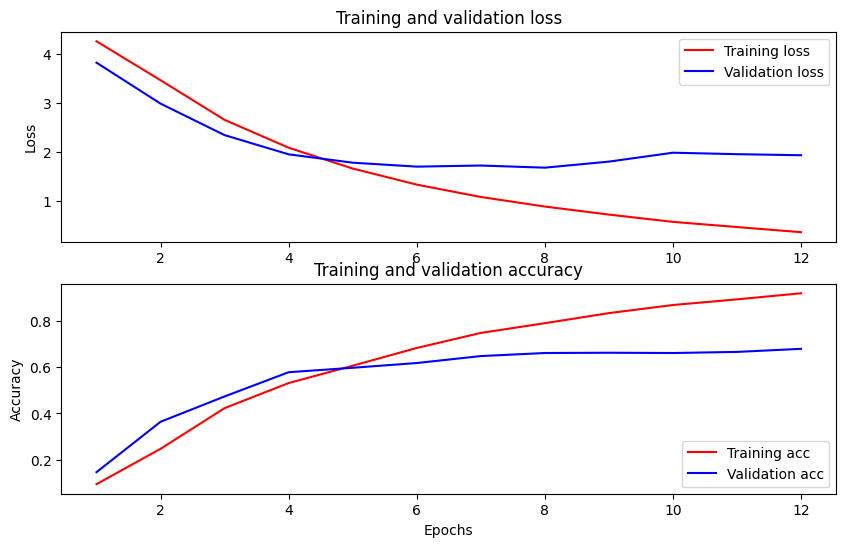

In [13]:

import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [15]:
dataset_name = 'model_h_robberta_clusters_12_4_CC_AdamW_368length'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./model_h_robberta_clusters_12_4_CC_AdamW_368length_bert\assets


INFO:tensorflow:Assets written to: ./model_h_robberta_clusters_12_4_CC_AdamW_368length_bert\assets


In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
import re

with open ('../processed_data/NL/NL_312-2019-012471.txt') as f:
    text=f.read() 
text = clean_text(text)
#print (text)

#not enough values to unpack (expected 2, got 1)
#input_ids = input_ids.unsqueeze(0)
#attention_mask = attention_mask.unsqueeze(0)

filename = 'NLP_model.sav' 
#loaded_model = pickle.load(open(filename, 'rb'))


encodings = tokenizer([text], truncation=True, padding=True)
ds = tf.data.Dataset.from_tensor_slices(dict(encodings))

print (ds)
ds=ds.batch(1, drop_remainder=True)
print(ds)
predictions = model.predict(ds)

mapping = {i: name for i, name in enumerate(y.columns)}

import numpy as np
print(mapping[np.argmax(predictions[0])])

FileNotFoundError: [Errno 2] No such file or directory: '../processed_data/NL/NL_312-2019-012471.txt'

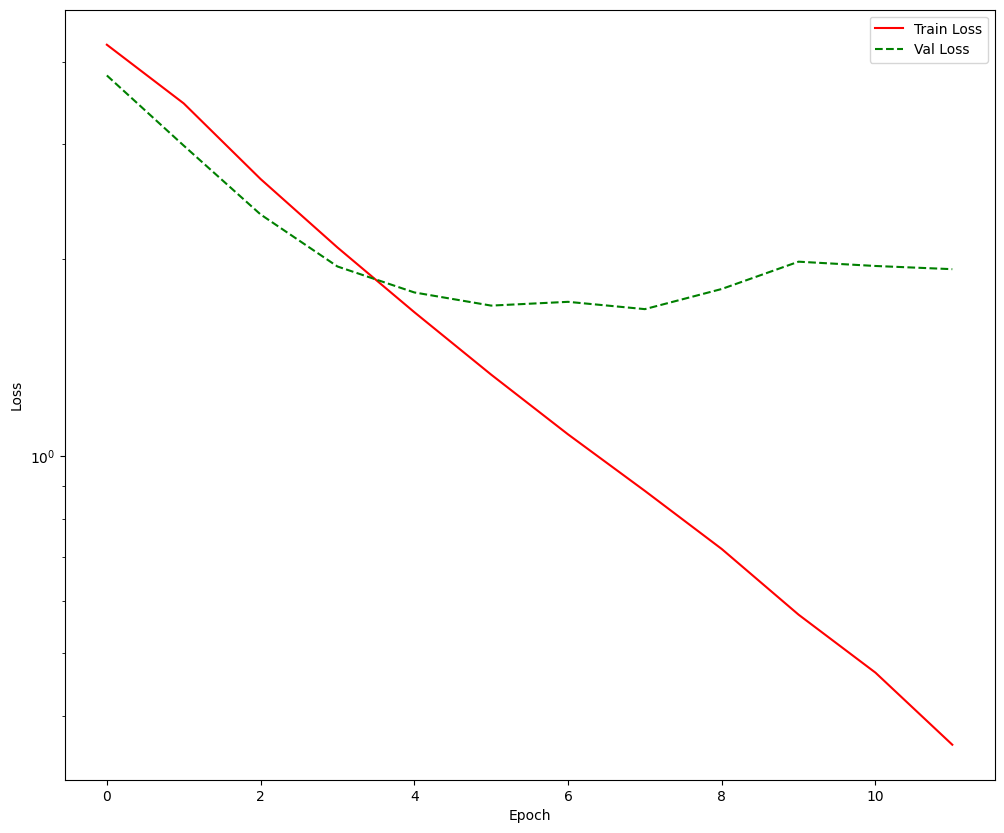

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history):
# Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color='red', label='Train Loss')
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color='green', label='Val Loss',
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()

plot_loss(history)

In [ ]:
!pip install seaborn
from sklearn.metrics import roc_curve,confusion_matrix,auc
import seaborn as sns

def plot_cm(y_true, y_pred, title):
    ''''
    input y_true-Ground Truth Labels
          y_pred-Predicted Value of Model
          title-What Title to give to the confusion matrix
    
    Draws a Confusion Matrix for better understanding of how the model is working
    
    return None
    
    '''
    
    figsize=(10,10)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
 
val_dataset=val_dataset.batch(1, drop_remainder=True) 
y_predict=model.predict(val_dataset, verbose=1)

ValueError: Exception encountered when calling layer "roberta" (type TFRobertaMainLayer).

too many values to unpack (expected 2)

Call arguments received:
  • input_ids=tf.Tensor(shape=(1, 1, 333), dtype=int32)
  • attention_mask=tf.Tensor(shape=(1, 1, 333), dtype=int32)
  • token_type_ids=None
  • position_ids=None
  • head_mask=None
  • inputs_embeds=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • past_key_values=None
  • use_cache=None
  • output_attentions=False
  • output_hidden_states=False
  • return_dict=True
  • training=False

In [ ]:
print (y_predict[0])
y_predict[float(y_predict[0])> 0.5] = 1
y_predict[y_predict <= 0.5] = 0
plot_cm(y_val, y_predict, 'Performance-Confusion Matrix')
plot_cm()


[[-0.49322274 -1.2551353   0.5227538  ...  2.23148    -0.60493404
  -0.66070664]
 [-0.14891274  5.2339973  -0.80021894 ... -2.2622523  -0.07557995
  -0.19552901]
 [ 6.042118   -0.89015144  0.2921647  ... -1.4149294   1.3690344
  -1.1068805 ]
 ...
 [10.672968    0.46779546  0.6906693  ... -1.3420739  -1.0007302
  -1.4504958 ]
 [-0.24870722  5.1164107  -0.22208434 ... -1.286181   -0.15097247
   0.2662612 ]
 [ 0.50567967  0.59395355 10.463406   ...  2.7373722  -1.7128971
  -1.2422782 ]]


TypeError: only size-1 arrays can be converted to Python scalars